**LSTM **

In [ ]:
!pip install pandas_datareader==0.9.0
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: pandas_datareader
    Found existing installation: pandas-datareader 0.10.0
    Uninstalling pandas-datareader-0.10.0:
      Successfully uninstalled pandas-datareader-0.10.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import datetime as dt

In [ ]:
##in US stock name the stock directly
# company = 'TSM'

##for tw stock
company = '5309.TWO'

###test data##
data_start= dt.datetime(2020,1,1)
data_end = dt.datetime(2024,2,29)
data = yf.download(company, data_start, data_end)
print(data.head(5))
print(data.tail(5))


[*********************100%%**********************]  1 of 1 completed

                 Open   High        Low      Close  Adj Close   Volume
Date                                                                  
2020-01-02  18.799999  19.40  17.299999  18.150000  18.150000  6733000
2020-01-03  17.100000  17.10  16.350000  16.350000  16.350000  1947154
2020-01-06  16.350000  16.35  15.600000  16.049999  16.049999  4500000
2020-01-07  16.299999  16.50  16.049999  16.350000  16.350000  2453000
2020-01-08  16.049999  16.25  16.049999  16.200001  16.200001  1093000
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2024-02-21  34.299999  34.450001  34.000000  34.000000  34.000000   644000
2024-02-22  34.150002  34.299999  33.750000  34.250000  34.250000   514000
2024-02-23  34.349998  34.500000  33.849998  33.849998  33.849998   708000
2024-02-26  33.849998  34.700001  33.750000  34.250000  34.250000  1440000
2024-02-27  34.900002  35.400002  34.200001  34.65000

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib as plyplot
from matplotlib.pyplot import tick_params

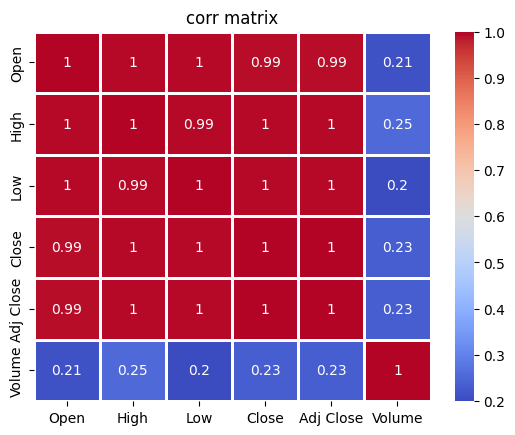

In [ ]:
matrix = data.corr()
sns.heatmap(matrix, annot=True,cmap='coolwarm', linewidth='1')
plt.title('corr matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
##determine the columns of data##
df=data[['Close']]
print(df.head())


                Close
Date                 
2020-01-02  18.150000
2020-01-03  16.350000
2020-01-06  16.049999
2020-01-07  16.350000
2020-01-08  16.200001


df_shape(1007, 1)


Text(0.5, 1.0, 'Stock Price Over Time')

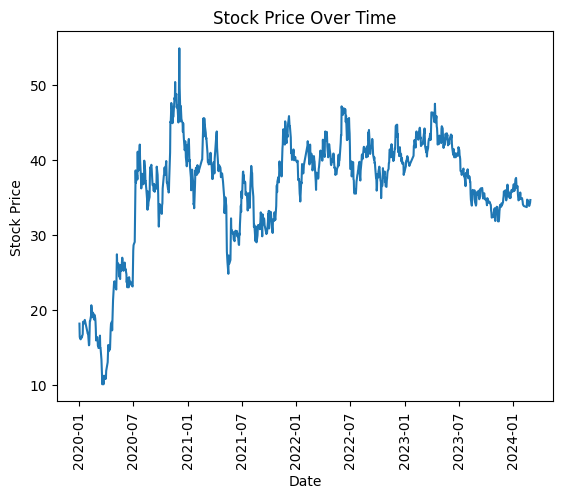

In [ ]:
print(f'df_shape{df.shape}')

plt.plot(df)
tick_params(axis ='x', rotation = 90)
plt.xlabel('Date')  # Add x-axis label
plt.ylabel('Stock Price')  # Add y-axis label
plt.title('Stock Price Over Time')  # Add plot title


In [ ]:
##scale data##
df_scaler = MinMaxScaler(feature_range =(0,1))
df_scaled = df_scaler.fit_transform(df)

print(df_scaled[:20])
print(f'df_scaled_shape{df_scaled.shape}')



[[0.18060199]
 [0.14046823]
 [0.13377924]
 [0.14046823]
 [0.13712375]
 [0.14158304]
 [0.13935337]
 [0.14938684]
 [0.18617612]
 [0.18394646]
 [0.18171684]
 [0.18060199]
 [0.19175026]
 [0.15050165]
 [0.15273131]
 [0.11594202]
 [0.11817168]
 [0.1516165 ]
 [0.18840579]
 [0.18840579]]
df_scaled_shape(1007, 1)


In [ ]:
print(len(df_scaled))

train_split = int(0.7 * len(df_scaled))
test_split = int(0.3 * len(df_scaled))

print(train_split)
print(test_split)

1007
704
302


In [ ]:

# Split the data into training and testing sets based on the split date
train_data = df_scaled[:train_split]

test_data=df_scaled[train_split:]

# print(train_data)
print(len(train_data))
print(len(test_data))

print(f'train_data:{train_data[:5]}')
print(f'test_data:{test_data[:5]}')



704
303
train_data:[[0.18060199]
 [0.14046823]
 [0.13377924]
 [0.14046823]
 [0.13712375]]
test_data:[[0.69119282]
 [0.67892974]
 [0.66443695]
 [0.67335561]
 [0.66889628]]


In [ ]:
#set time step to 5 days, lets say, memorize the last 5 days data to predict the next one
prediction_days = 5

##train_data##
x_train = []
y_train = []
#so the x will be 5, becos from 5 to the len 251
#use 5 columns(input) to predict the output
for x in range(prediction_days, len(train_data)):
  x_train.append(train_data[x-prediction_days:x,0:])
  y_train.append(train_data[x,0])

##test_data##
x_test = []
y_test = []
#so the x will be 5, becos from 5 to the len 251
#use 5 columns(input) to predict the output
for x in range(prediction_days, len(test_data)):
  x_test.append(test_data[x-prediction_days:x,0:])
  y_test.append(test_data[x,0])

print (x_train[:2])
print (y_train[:2])

print (x_test[:2])
print (y_test[:2])
print(type(x_train))
print(type(y_train))


[array([[0.18060199],
       [0.14046823],
       [0.13377924],
       [0.14046823],
       [0.13712375]]), array([[0.14046823],
       [0.13377924],
       [0.14046823],
       [0.13712375],
       [0.14158304]])]
[0.14158303765354877, 0.1393533748108998]
[array([[0.69119282],
       [0.67892974],
       [0.66443695],
       [0.67335561],
       [0.66889628]]), array([[0.67892974],
       [0.66443695],
       [0.67335561],
       [0.66889628],
       [0.70345591]])]
[0.7034559051097273, 0.7012262847943599]
<class 'list'>
<class 'list'>


In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

699
699
298
298


In [ ]:
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
# (number_of_samples, number_of_time_steps, number_of_features)
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

print(type(x_train))
print(type(y_train))

(699, 5, 1)
(699,)
(298, 5, 1)
(298,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# ###analysis the epoch and batch###

# # input shape=(times step, input features)
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu'))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True, activation='relu'))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units=1, activation='linear'))

# #Compile model
# model.compile(optimizer='adam', loss='mean_squared_error')

# #Values to experiment with
# batch_sizes=[5, 10, 15,20]
# epochs = [5,10,50,100]

# #loop function to compute
# for epoch_values in epochs:
#   losses=[] #store the loss for different batch sizes

#   for batch_values in batch_sizes:
#     print(f'\n Batch size{batch_values} and {epoch_values} epoch')
#     history = model.fit(x_train, y_train, epochs=epoch_values, batch_size=batch_values, verbose=0)
#     losses.append(history.history['loss'][-1])#To store the final loss of every batch size
#   print(losses)
#   plt.plot(batch_sizes, losses, marker='o', label=f'Ephochs{epoch_values}')

# plt.title('loss changes')
# plt.xlabel('batch')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam,SGD

In [ ]:
# ####analysis the best optimizer###
# optimizers=[Adam(learning_rate=0.001), SGD(learning_rate=0.01)]

# # input shape=(times step, input features)
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],5)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# #create a dataframe to analysis the result of optimizers
# loss_df=pd.DataFrame(columns=['Optimizer', 'Loss'])

# for optimizer in optimizers:

#   #Compile model
#   #use epochs=100, and batch=20 which has obtain above to compile
#   model.compile(optimizer=optimizer, loss='mean_squared_error')
#   history = model.fit(x_train, y_train, epochs=100, batch_size=20, verbose=0)
#   losses=history.history['loss']

#   #only take the last result of every optimizers with (losses[-1])
#   loss_df=loss_df.append({'Optimizer':optimizer.__class__.__name__,'Loss':losses[-1]},ignore_index=True)
#   plt.plot(losses, label=f'loss{optimizer.__class__.__name__}')
# plt.title('loss changes')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()
# plt.show()
# print(loss_df)

Epoch 1/100
35/35 [==============================] - 5s 44ms/step - loss: 0.1258 - val_loss: 0.0233
Epoch 2/100
35/35 [==============================] - 2s 46ms/step - loss: 0.0159 - val_loss: 0.0011
Epoch 3/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0087 - val_loss: 0.0020
Epoch 4/100
35/35 [==============================] - 1s 24ms/step - loss: 0.0078 - val_loss: 7.9022e-04
Epoch 5/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0078 - val_loss: 7.9083e-04
Epoch 6/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0071 - val_loss: 7.8553e-04
Epoch 7/100
35/35 [==============================] - 1s 26ms/step - loss: 0.0070 - val_loss: 9.3838e-04
Epoch 8/100
35/35 [==============================] - 1s 24ms/step - loss: 0.0079 - val_loss: 8.2419e-04
Epoch 9/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0056 - val_loss: 9.2379e-04
Epoch 10/100
35/35 [==============================] - 1s 23ms/step - loss: 0

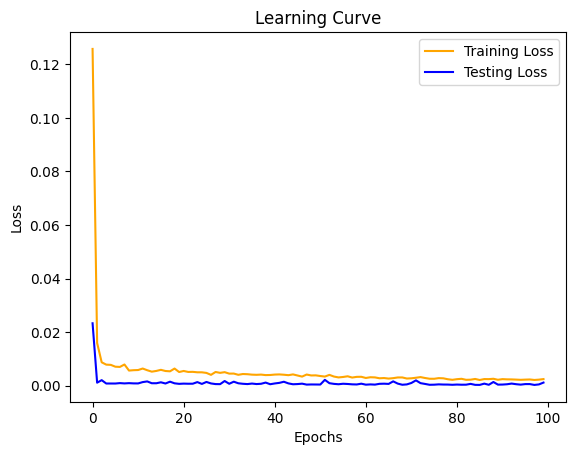

In [ ]:
###learning rate plotting for train and test
#the loss of Adam and 20batch, 100epochs are lower loss
# input shape=(times step, input features)
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(units=150, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history=model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=20, epochs=100, verbose=1)
#store the loss
train_loss=history.history['loss']
test_loss=history.history['val_loss']

#plot learning rate
plt.plot(train_loss, label='Training Loss', color='orange')
plt.plot(test_loss, label='Testing Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [ ]:
#0.018/0.035(for 4 inputs)
#0.0020/0.0025(for 1 inputs)
#50 epochs loss: 0.0039 - val_loss: 0.0026

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


22/22 [==============================] - 1s 16ms/step
mse_train:0.0017289010394841203
r2_train:0.9499513308997024

prediction_train:[[0.15018354]]
y_orig_train:[0.14158304]
prediction_train.shape:(699, 1)
y_train.shape:(699,)

y_train_reshape.shape:(699, 1)

prediction_train_scaled:[[16.785732]]
y_train_scaled:[[16.39999962]]


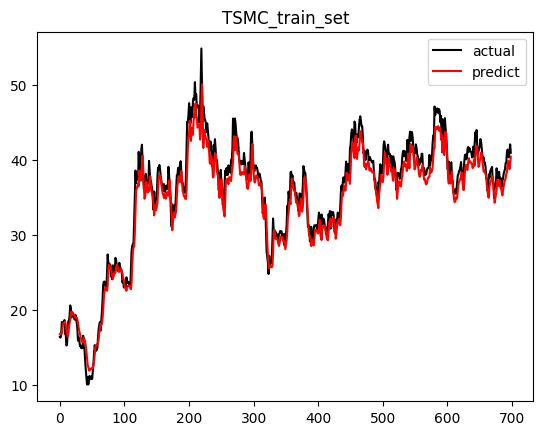

In [ ]:

prediction_train=model.predict(x_train)
mse_train=mean_squared_error(y_train, prediction_train)
r_square_train= r2_score(y_train, prediction_train)
print(f'mse_train:{mse_train}')
print(f'r2_train:{r_square_train}\n')


print(f"prediction_train:{prediction_train[:1]}")
print(f"y_orig_train:{y_train[:1]}")
# print(f"y_train_orig_scaled:{y_train_scaled[:1]}")

# y_train_orig_scaled=y_scaler.inverse_transform(y_train)

print(f"prediction_train.shape:{prediction_train.shape}")
print(f"y_train.shape:{y_train.shape}\n")

y_train_reshape=y_train.reshape(-1,1)
print(f"y_train_reshape.shape:{y_train_reshape.shape}\n")

prediction_train_scaled=df_scaler.inverse_transform(prediction_train)
y_train_scaled=df_scaler.inverse_transform(y_train_reshape)

print(f"prediction_train_scaled:{prediction_train_scaled[:1]}")
print(f"y_train_scaled:{y_train_scaled[:1]}")

plt.plot(y_train_scaled, color='black', label=f'actual')
plt.plot(prediction_train_scaled, color='red', label=f'predict')
plt.title(f"TSMC_train_set")
plt.legend()

# plt.xlim(990, 1000)  # Set the limits for the x-axis
# plt.ylim(100, 300)  # Set the limits for the y-axis

plt.show()

10/10 [==============================] - 0s 8ms/step
prediction:[[0.63816404]]
y_test:[0.70345591]

mse_test:0.0011408111828083091
r_square_test:0.8476856889596066

prediction.shape:(298, 1)
y_test.shape:(298,)

y_test_reshape.shape:(298, 1)

y_test_prediction:[[38.671658]]
y_test_scaled:[[41.59999847]]


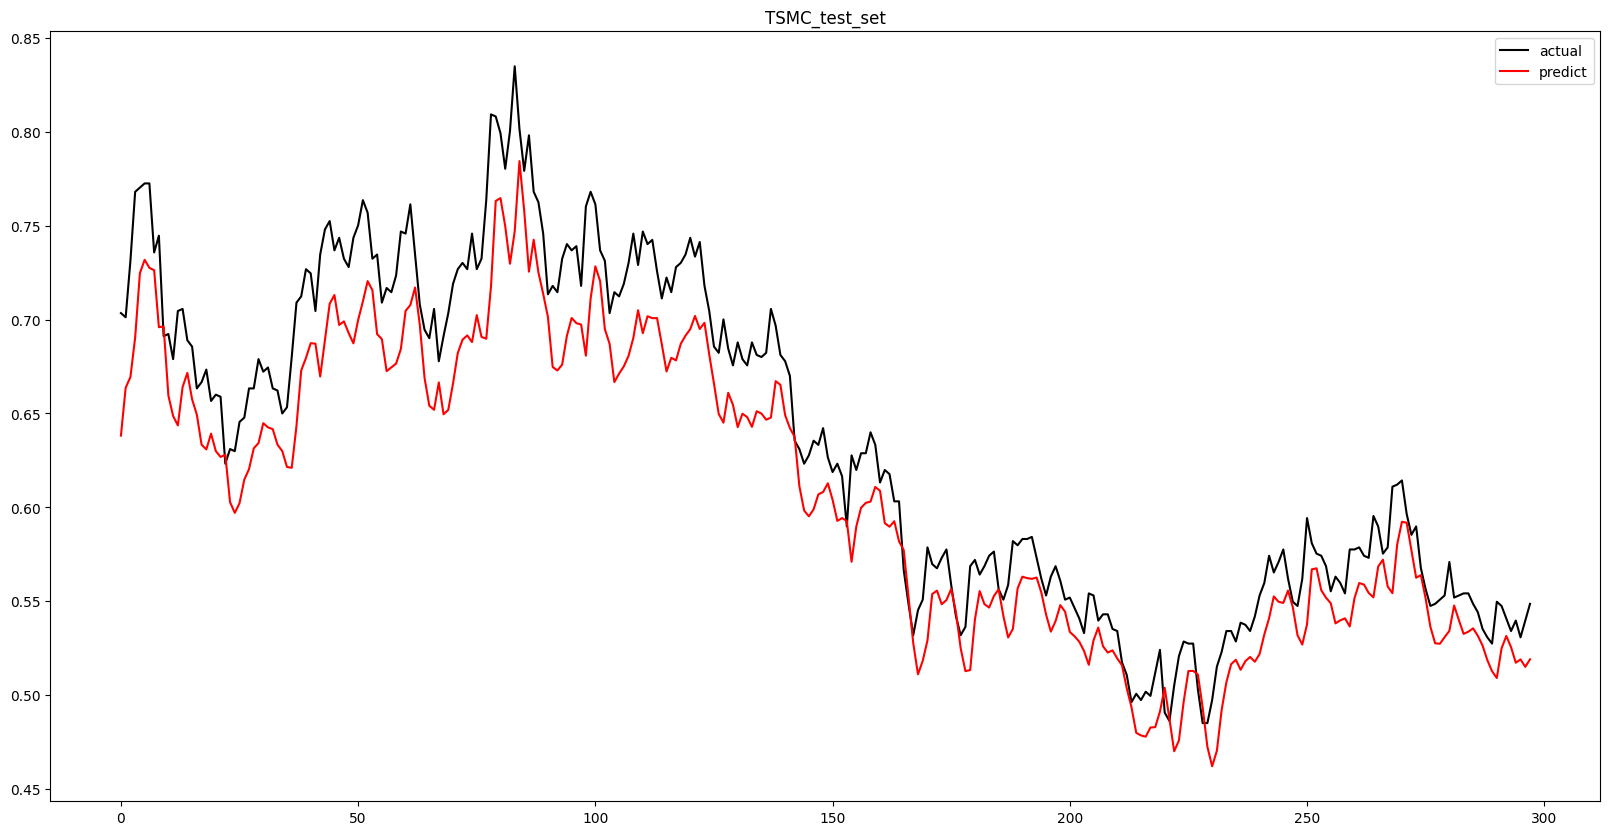

In [ ]:
prediction=model.predict(x_test)

print(f"prediction:{prediction[:1]}")
print(f"y_test:{y_test[:1]}\n")

mse_test=mean_squared_error(y_test, prediction)
r_square_test= r2_score(y_test, prediction)
print(f'mse_test:{mse_test}')
print(f'r_square_test:{r_square_test}\n')

print(f"prediction.shape:{prediction.shape}")
print(f"y_test.shape:{y_test.shape}\n")

#reshape the y_test so can inverse transform
y_test_reshape = y_test.reshape(-1,1)
print(f"y_test_reshape.shape:{y_test_reshape.shape}\n")

#scaled back the orig number
y_test_prediction= df_scaler.inverse_transform(prediction)
y_test_scaled= df_scaler.inverse_transform(y_test_reshape)

print(f"y_test_prediction:{y_test_prediction[:1]}")
print(f"y_test_scaled:{y_test_scaled[:1]}")

plt.figure(figsize=(20,10))
plt.plot(y_test, color='black', label=f'actual')
plt.plot(prediction, color='red', label=f'predict')
plt.title(f"TSMC_test_set")
plt.legend()


# plt.xlim(250, 350)  # Set the limits for the x-axis
# plt.ylim(0, 1)  # Set the limits for the y-axis
plt.show()

In [ ]:
# print(df_scaled[558:])
print(df_scaled.shape)

# Initialize a list to store the predicted prices
predicted_prices = []

#take the last sequence
number_of_days=5
last_sequence = df_scaled[-number_of_days:]
print(last_sequence)
print(last_sequence.shape)
print(f'this{last_sequence.shape[1]}')

# (number_of_samples, number_of_time_steps, number_of_features)
last_sequence_reshape= last_sequence.reshape(1,number_of_days,last_sequence.shape[1])
print(last_sequence_reshape.shape)
print(last_sequence_reshape)




(1007, 1)
[[0.53400221]
 [0.53957635]
 [0.53065769]
 [0.53957635]
 [0.548495  ]]
(5, 1)
this1
(1, 5, 1)
[[[0.53400221]
  [0.53957635]
  [0.53065769]
  [0.53957635]
  [0.548495  ]]]


In [ ]:
###For 1 day prediction
# next_day_prediction = model.predict(last_sequence_reshape)
# print(next_day_prediction)
# # Append the prediction to the list
# last_sequence=np.append(last_sequence,next_day_prediction)
# print(f'last_sequence{last_sequence}')
# new_last_sequence=last_sequence[1:]
# print(f'new_last_sequence{new_last_sequence}')
# print(f'new_last_sequence.shape{new_last_sequence.shape}')
# new_last_sequence_reshape=new_last_sequence.reshape(1,prediction_days,1)
# print(f'new_last_sequence_reshape.shape{new_last_sequence_reshape.shape}')
# last_sequence_reshape=new_last_sequence_reshape
# print(f'last_sequence_reshape{last_sequence_reshape}')


In [ ]:
future_pred=[]

for _ in range(10):
  next_day_prediction = model.predict(last_sequence_reshape)
  # Append the prediction to the list
  last_sequence=np.append(last_sequence,next_day_prediction)
  new_last_sequence=last_sequence[-number_of_days:]
  new_last_sequence_reshape=new_last_sequence.reshape(1,number_of_days,1)
  last_sequence_reshape=new_last_sequence_reshape
  next_day_prediction_inverse=df_scaler.inverse_transform(next_day_prediction)
  future_pred.append(next_day_prediction_inverse.flatten())

  print(f'next_day_prediction{next_day_prediction}')
  print(f'next_day_prediction_inverse{df_scaler.inverse_transform(next_day_prediction)}')


1/1 [==============================] - 0s 23ms/step
next_day_prediction[[0.5280884]]
next_day_prediction_inverse[[33.734764]]
1/1 [==============================] - 0s 24ms/step
next_day_prediction[[0.51731145]]
next_day_prediction_inverse[[33.25142]]
1/1 [==============================] - 0s 24ms/step
next_day_prediction[[0.50140584]]
next_day_prediction_inverse[[32.53805]]
1/1 [==============================] - 0s 24ms/step
next_day_prediction[[0.48534364]]
next_day_prediction_inverse[[31.817663]]
1/1 [==============================] - 0s 26ms/step
next_day_prediction[[0.46931198]]
next_day_prediction_inverse[[31.098644]]
1/1 [==============================] - 0s 27ms/step
next_day_prediction[[0.45385644]]
next_day_prediction_inverse[[30.405464]]
1/1 [==============================] - 0s 29ms/step
next_day_prediction[[0.43878636]]
next_day_prediction_inverse[[29.72957]]
1/1 [==============================] - 0s 30ms/step
next_day_prediction[[0.42510396]]
next_day_prediction_inverse[[

[*********************100%%**********************]  1 of 1 completed

                Close
Date                 
2024-02-29  35.000000
2024-03-01  34.700001
2024-03-04  35.500000
2024-03-05  37.299999
2024-03-06  36.950001
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[array([33.734764], dtype=float32), array([33.25142], dtype=float32), array([32.53805], dtype=float32), array([31.817663], dtype=float32), array([31.098644], dtype=float32), array([30.405464], dtype=float32), array([29.72957], dtype=float32), array([29.115913], dtype=float32), array([28.560812], dtype=float32), array([28.06113], dtype=float32)]


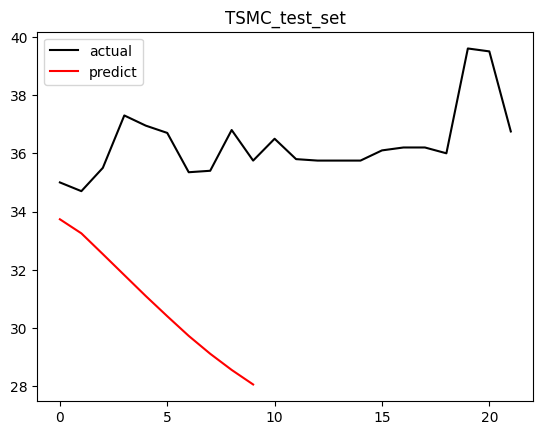

In [ ]:

test_data_start= dt.datetime(2024,2,29)
test_data_end = dt.datetime(2024,4,1)
predi_data = yf.download(company, test_data_start, test_data_end)
##determine the columns of data##
df=predi_data[['Close']]
print(df.head())

print(type(next_day_prediction))
print(type(df))

array = df.values

# print(array)
print(type(array))
print(future_pred)

plt.plot(array, color='black', label=f'actual')
plt.plot(future_pred, color='red', label=f'predict')
plt.title(f"TSMC_test_set")
plt.legend()
plt.show()
